In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train = pd.read_csv('Toxic_Multi/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.drop(columns = ['id'], axis = 1, inplace = True)

In [4]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train[train['comment_text'] == ' ']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [6]:
X =  train['comment_text']
y =  train.drop(['comment_text'],axis = 1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [8]:
# using keras tokenizer

max_len = 1500
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test))

X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

word_index = token.word_index

## RNN

In [9]:
model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 300, input_length = max_len))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(6, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 63,142,106
Trainable params: 63,142,106
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_history = model_rnn.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=2, batch_size = 128)

Epoch 1/2
873/873 [==============================] - 2315s 3s/step - loss: 0.1077 - accuracy: 0.9697 - val_loss: 0.1030 - val_accuracy: 0.9294
Epoch 2/2
873/873 [==============================] - 2399s 3s/step - loss: 0.0711 - accuracy: 0.9631 - val_loss: 0.0683 - val_accuracy: 0.9938


In [11]:
rnn_loss, rnn_acc = model_rnn.evaluate(X_test_pad, y_test)
print(f"Loss :- {rnn_loss}, Accuracy :- {rnn_acc}")

1496/1496 [==============================] - 586s 392ms/step - loss: 0.0683 - accuracy: 0.9938
Loss :- 0.06829474866390228, Accuracy :- 0.9937541484832764


In [17]:
rnn_preds = model_rnn.predict(X_test_pad)

1496/1496 [==============================] - 501s 335ms/step


In [18]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [19]:
rnn_preds = pd.DataFrame(rnn_preds)
rnn_preds.head(20)

,0,1,2,3,4,5
0,0.013884,0.000269,0.003415,0.000226,0.004138,0.000639
1,0.041192,0.001095,0.008067,0.001419,0.010734,0.002986
2,0.012317,0.000945,0.003877,0.001200,0.004409,0.002227
3,0.009827,0.000538,0.003563,0.000686,0.003872,0.001553
4,0.037726,0.000572,0.006785,0.000557,0.008416,0.001656
5,0.014035,0.000261,0.003906,0.000281,0.004820,0.000796
6,0.028163,0.000721,0.007021,0.000694,0.007676,0.001700
7,0.013011,0.000698,0.004079,0.000850,0.004068,0.001715
8,0.016360,0.000630,0.004849,0.000656,0.005117,0.001678
9,0.024173,0.000593,0.006651,0.000586,0.007069,0.002116


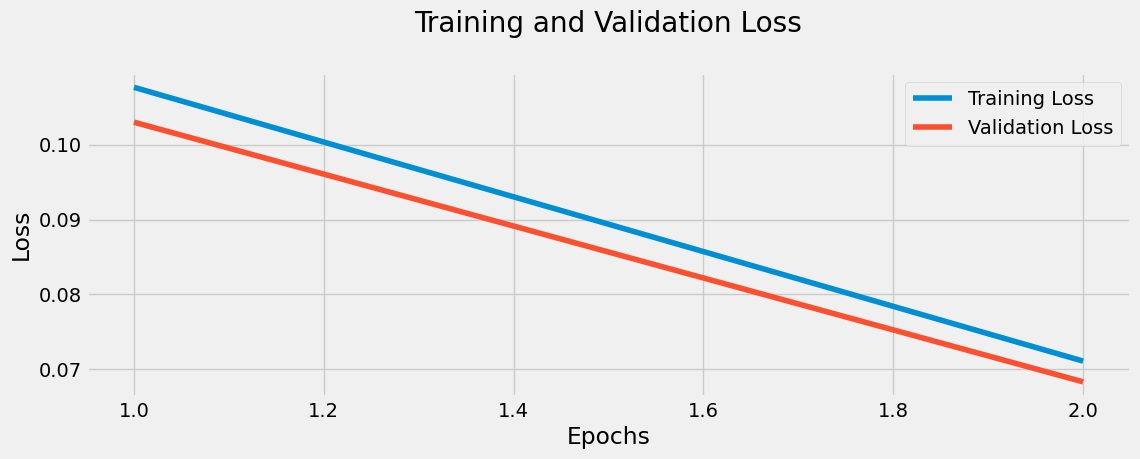

In [20]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 3)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

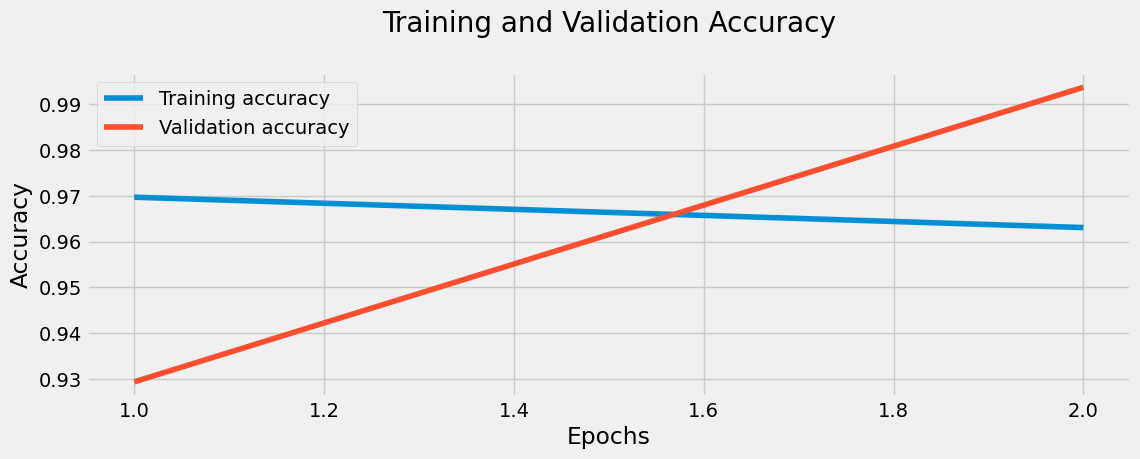

In [21]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 3)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LSTM

In [17]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1, 300 , input_length = max_len))
model_lstm.add(CuDNNLSTM(100))
model_lstm.add(Dense(6, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 300)         63101400  
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 100)               160800    
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 63,262,806
Trainable params: 63,262,806
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model_history = model_lstm.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test),epochs = 3, batch_size = 64)

Epoch 1/3
1746/1746 [==============================] - 284s 162ms/step - loss: 0.0726 - accuracy: 0.9844 - val_loss: 0.0495 - val_accuracy: 0.9938
Epoch 2/3
1746/1746 [==============================] - 283s 162ms/step - loss: 0.0404 - accuracy: 0.9940 - val_loss: 0.0482 - val_accuracy: 0.9932
Epoch 3/3
1746/1746 [==============================] - 282s 161ms/step - loss: 0.0300 - accuracy: 0.9792 - val_loss: 0.0501 - val_accuracy: 0.9773


In [20]:
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_pad, y_test)

1496/1496 [==============================] - 33s 22ms/step - loss: 0.0501 - accuracy: 0.9773


In [21]:
lstm_preds = model_lstm.predict(X_test_pad)

1496/1496 [==============================] - 30s 20ms/step


In [22]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [23]:
lstm_preds = pd.DataFrame(lstm_preds)
lstm_preds.head(20)

,0,1,2,3,4,5
0,0.000570,0.000010,0.000126,0.000046,0.000097,0.000023
1,0.046324,0.000481,0.001736,0.007691,0.005534,0.002805
2,0.895633,0.000900,0.046222,0.001145,0.196604,0.011923
3,0.002097,0.000076,0.000298,0.001121,0.000567,0.000770
4,0.000253,0.000013,0.000053,0.000037,0.000039,0.000009
5,0.000271,0.000006,0.000038,0.000018,0.000032,0.000012
6,0.031850,0.000106,0.001450,0.001901,0.002328,0.001589
7,0.000181,0.000009,0.000092,0.000027,0.000024,0.000012
8,0.003200,0.000058,0.001226,0.000245,0.000556,0.000091
9,0.000488,0.000016,0.000207,0.000056,0.000051,0.000013


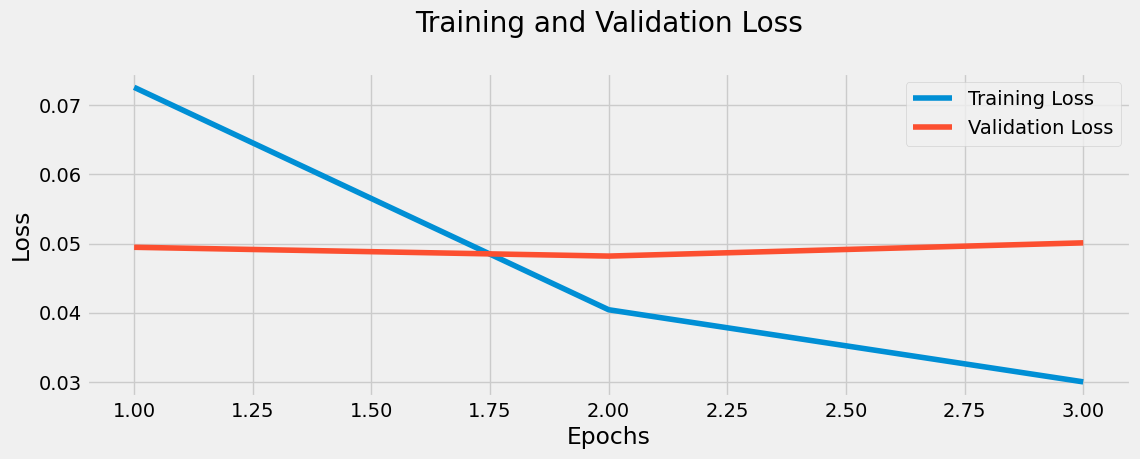

In [24]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

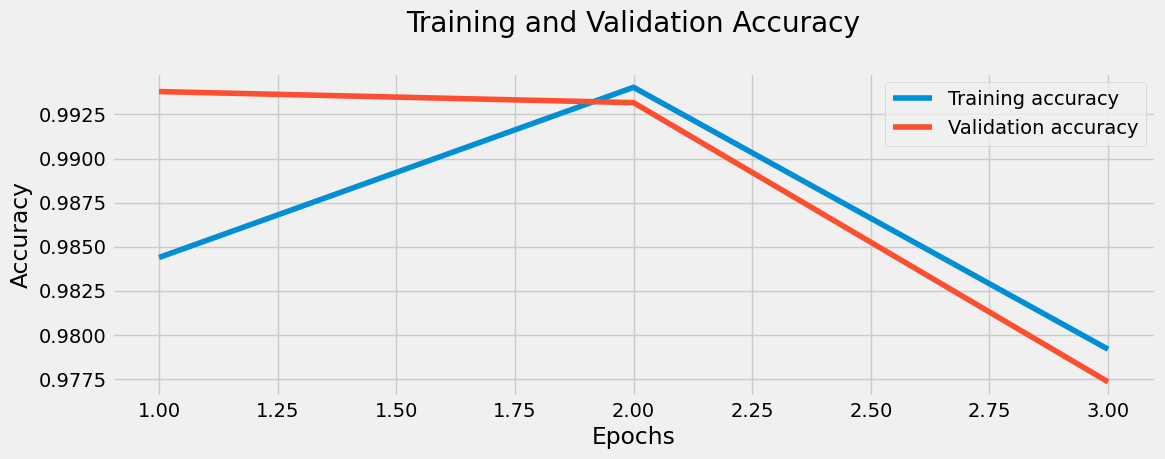

In [25]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### GRU

In [9]:
## Creating model

model_gru=Sequential()
model_gru.add(Embedding(len(word_index) + 1, 300 , input_length=max_len))
model_gru.add(CuDNNGRU(300))
model_gru.add(Dense(6, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 300)               541800    
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
Total params: 63,645,006
Trainable params: 63,645,006
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model_history = model_gru.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=3, batch_size = 64)

Epoch 1/3
1746/1746 [==============================] - 409s 232ms/step - loss: 0.0621 - accuracy: 0.9805 - val_loss: 0.0460 - val_accuracy: 0.9934
Epoch 2/3
1746/1746 [==============================] - 408s 234ms/step - loss: 0.0363 - accuracy: 0.9607 - val_loss: 0.0443 - val_accuracy: 0.9755
Epoch 3/3
1746/1746 [==============================] - 407s 233ms/step - loss: 0.0246 - accuracy: 0.8066 - val_loss: 0.0518 - val_accuracy: 0.6353


In [11]:
gru_loss, gru_acc = model_gru.evaluate(X_test_pad, y_test)

1496/1496 [==============================] - 50s 33ms/step - loss: 0.0518 - accuracy: 0.6353


In [12]:
gru_preds = model_gru.predict(X_test_pad)

1496/1496 [==============================] - 45s 30ms/step


In [13]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [14]:
gru_preds = pd.DataFrame(gru_preds)
gru_preds.head(20)

,0,1,2,3,4,5
0,0.000064,0.000016,0.000038,0.000032,0.000037,0.000004
1,0.875345,0.081567,0.710801,0.230890,0.035486,0.006458
2,0.715348,0.000277,0.007765,0.002230,0.133848,0.001523
3,0.000266,0.000019,0.000082,0.000014,0.000018,0.000128
4,0.000070,0.000005,0.000046,0.000006,0.000012,0.000002
5,0.000021,0.000002,0.000009,0.000003,0.000005,0.000005
6,0.008654,0.000028,0.000691,0.000064,0.001467,0.000290
7,0.000008,0.000003,0.000010,0.000003,0.000001,0.000004
8,0.000044,0.000011,0.000063,0.000036,0.000151,0.000034
9,0.000020,0.000008,0.000057,0.000008,0.000012,0.000004


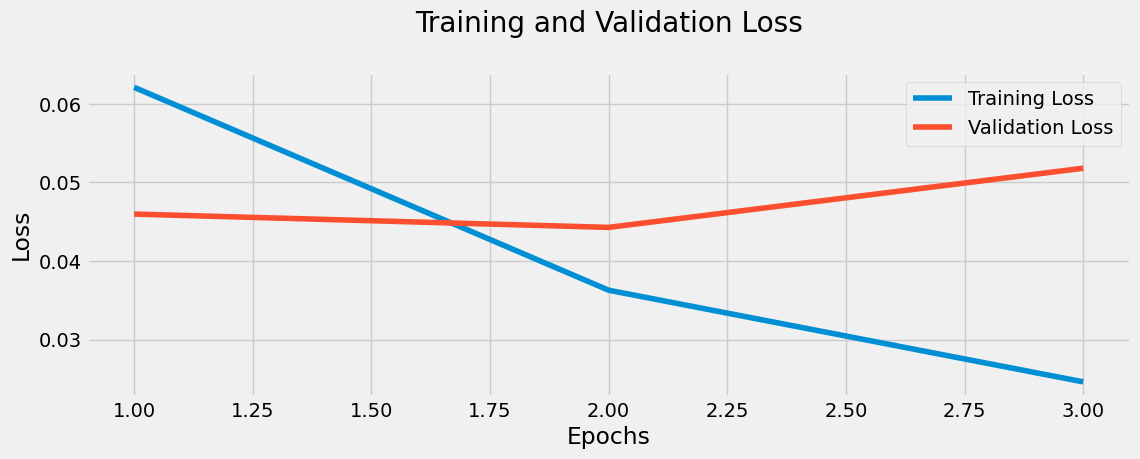

In [15]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()